In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [3]:
from implementations import *

## Do your thing crazy machine learning thing here :) ...

In [4]:
# Separate the data according to the value of column 24 (PRI_jet_num) 

def separate(y, tX, ids):
    
    split_x = []
    split_y = []
    split_ids = []
    
    jet_column_nbr = 22
    
    for i in range(4):
        
        split_x.append(tX[np.where(tX[:,jet_column_nbr] == i)])
        split_y.append(y[np.where(tX[:,jet_column_nbr] == i)])
        split_ids.append(ids[np.where(tX[:,jet_column_nbr] == i)])
    
    
    
    return split_x, split_y, split_ids

In [5]:
split_x, split_y, split_ids = separate(y, tX, ids)

In [6]:
#remove the columns from each set of data given a boolean array

def removeNone(data, selection):
   
    cleaned=[]
    
    for i in range(4):
        curr_data = data[i]
        
        cleaned.append(curr_data[:,selection[i]])
      
    return cleaned
    
    

In [7]:
#print statistics about the None values (-999) for each columns
#returns a boolean array that can be used to filter the columns that have 100% of undefined values (-999)
def dataStatistics(data):
    
    stats=[]
    
    for i in range(4):
        
        print("Statistics ")
        print("Type :")
        print(i)
        
        
        nones = (data[i] == -999)
    
        mean = np.sum(nones, axis=0)/nones.shape[0]
        print(mean) 
        stats.append(mean != 1)
    
    return stats
    

In [8]:
selection = dataStatistics(split_x)

Statistics 
Type :
0
[0.26145747 0.         0.         0.         1.         1.
 1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 1.         1.         1.         1.         1.         0.        ]
Statistics 
Type :
1
[0.09751883 0.         0.         0.         1.         1.
 1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         1.         1.         0.        ]
Statistics 
Type :
2
[0.05859584 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
Statistics 
Type :
3
[0.0

In [9]:
cleaned = removeNone(split_x, selection)



# Now we can either drop the lines with residual Nones or replace the Nones by the median value

In [10]:
#replace the value of column 0 (can be None sometimes) by the median value of this column

def putMedianInsteadOfNone(cleaned):
    
    completed_data = []
    
    for i in range(4):
        #current PRI_jet_num
        current = cleaned[i]
        
        median = np.median(current[np.where(current[:,0] != -999)], axis = 0)
        
        #replace -999 by median value
        current[np.where(current[:,0] == -999)] = median
        
        completed_data.append(current)
    
    
    return completed_data
    
    

In [11]:
cleaned_with_median = putMedianInsteadOfNone(cleaned)



In [12]:
#Instead of putting the median we can simply drop the data where columns 0 == -999
def dropLineIfNone(cleaned, split_y, split_ids):
    
    res_x=[]
    res_y=[]
    res_ids=[]
    
    for i in range(4):
        
        current = cleaned[i]
        
        drop_indexes = np.where(current[:,0] != -999)
        
        res_x.append(current[drop_indexes])
        res_y.append(current[drop_indexes])
        res_ids.append(current[drop_indexes])
        
    return res_x, res_y, res_ids

In [13]:
dropped_x, dropped_y, dropped_ids = dropLineIfNone(cleaned, split_y, split_ids)


## At this point, the first values in each of the split data has a PRI_jet_num = 0, then 1 and so on. The data is clean and we can work with it.

In [14]:
initial_w = np.zeros(cleaned_with_median[0].shape[1])
median_cleaned_x_0_lsq_GD = least_squares_GD(split_y[0], normalize(cleaned_with_median[0]), initial_w, 500, 0.1)

In [15]:
print(median_cleaned_x_0_lsq_GD)

(array([ 0.2155689 , -0.53554557, -0.40401874,  0.03959931,  0.08147027,
        0.03959934,  0.16148251,  0.03462872,  0.10957412,  0.5842968 ,
        0.05218412,  0.04930115, -0.04715568,  0.05726908,  0.0508691 ,
       -0.07238437,  0.03803752, -0.00064042,  0.05024209,  0.05024209]), 0.29714565802617193)


In [16]:
median_cleaned_x_0_lsq_SGD = least_squares_SGD(split_y[0], normalize(cleaned_with_median[0]), initial_w, 500, 0.001)

In [17]:
print(median_cleaned_x_0_lsq_SGD)

(array([-0.03415192, -0.10838841, -0.02479375,  0.022209  ,  0.02761712,
        0.022209  , -0.01267088,  0.02689357,  0.0322059 ,  0.0434371 ,
        0.02972195,  0.03074625, -0.02174099,  0.03006534,  0.02920467,
       -0.01581236,  0.03042716, -0.05358197,  0.02996181,  0.02996181]), 0.36323275355184187)


In [36]:
median_cleaned_x_0_lsq = least_squares(split_y[0], normalize(cleaned_with_median[0]))

In [37]:
print(median_cleaned_x_0_lsq)

(array([ 1.19348795e-01, -3.20910721e-01, -7.11010650e-01, -3.62337265e+03,
        2.92434116e+01,  3.62345882e+03, -7.97192057e+00, -1.48451089e+01,
       -9.21399478e-01,  8.74154019e+00,  1.22203119e-02,  9.00427055e-03,
        8.51383345e+00,  1.42330453e-01,  1.82845411e-02, -8.31033254e-02,
       -1.72379530e-01,  3.24837923e-02, -9.72705128e+00, -9.72705128e+00]), 0.2599109628358987)


In [20]:
median_cleaned_x_0_ridge = ridge_regression(split_y[0], normalize(cleaned_with_median[0]), 0.037)

In [181]:
print(median_cleaned_x_0_ridge)

NameError: name 'median_cleaned_x_0_ridge' is not defined

In [180]:
median_cleaned_x_0_log = logistic_regression(split_y[0], normalize(cleaned_with_median[0]), initial_w, 10000, 0.01)

NameError: name 'logistic_regression' is not defined

In [ ]:
print(median_cleaned_x_0_log)

## Cross Validation

In [12]:
#method to split the training set into a (new) training set and a test set (same as in lab03)

def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
 
    # split the data based on the given ratio

    training_nbr = int(x.shape[0] * ratio)
    indexes = np.random.choice(x.shape[0],training_nbr, replace=False)
    
    x_train = x[indexes]
    y_train = y[indexes]
    x_test = np.delete(x, indexes, axis = 0)
    y_test = np.delete(y, indexes, axis = 0)
    
    
    return x_train, y_train, x_test, y_test

In [85]:
#perform cross-validation 

def crossValidation(x, y, splitRatio, seed =1):
    
    x_train, y_train, x_test, y_test = split_data(x, y, splitRatio, seed)
    
    a_training = []
    a_testing = []
    
    #normalize data (DANGER: the test set must be normalized with the training set's mean and std)
    mean = np.mean(x_train)
    std = np.std(x_train)
    
    x_train = (x_train - mean) / std
    x_test = (x_test - mean) / std
    
    # define parameter (just add more for loops if there are more parameters for the model)
    lambdas = np.arange(0,1,0.05)
    
    for ind, lambda_ in enumerate(lambdas):
        
        #train model with these parameters and compute the error (MSE or RMSE)
        
        #w_star, e_tr = ridge_regression(y_train,x_train, lambda_)
        #w_star, e_tr = logistic_regression(y_train, x_train,np.ones(x_train.shape[1])  ,400, lambda_)
        w_star, e_tr = least_squares_GD(y_train, x_train,np.ones(x_train.shape[1])  ,400, lambda_)
        #w_star, e_tr = least_squares_SGD(y_train, x_train,np.ones(x_train.shape[1])  ,400, lambda_)
        
        
        #compare the prediction with the reality
        accuracy_training = np.count_nonzero(predict_labels(w_star, x_train) + y_train)/len(y_train)
        accuracy_testing = np.count_nonzero(predict_labels(w_star, x_test) + y_test)/len(y_test)
        
        a_training.append(accuracy_training)
        a_testing.append(accuracy_testing)
        
        print("lambda={l:.3f}, Training Accuracy={tr}, Testing Accuracy={te}".format(
               l=lambda_, tr=a_training[ind], te=a_testing[ind]))
        
    plt.plot(lambdas, a_training,'r--' , lambdas, a_testing, 'g--')
    plt.show
    
    return lambdas[np.argmax(a_testing)]

lambda=0.000, Training Accuracy=0.6038774018828182, Testing Accuracy=0.5969052224371373
lambda=0.050, Training Accuracy=0.6945650460674319, Testing Accuracy=0.6928433268858801
lambda=0.100, Training Accuracy=0.6974021693963232, Testing Accuracy=0.6952933591231464
lambda=0.150, Training Accuracy=0.3582656292538939, Testing Accuracy=0.34906511927788525
lambda=0.200, Training Accuracy=0.3582656292538939, Testing Accuracy=0.34906511927788525
lambda=0.250, Training Accuracy=0.3582656292538939, Testing Accuracy=0.34906511927788525
lambda=0.300, Training Accuracy=0.3582656292538939, Testing Accuracy=0.34906511927788525
lambda=0.350, Training Accuracy=0.3582656292538939, Testing Accuracy=0.34906511927788525
lambda=0.400, Training Accuracy=1.0, Testing Accuracy=1.0
lambda=0.450, Training Accuracy=1.0, Testing Accuracy=1.0
lambda=0.500, Training Accuracy=1.0, Testing Accuracy=1.0
lambda=0.550, Training Accuracy=1.0, Testing Accuracy=1.0
lambda=0.600, Training Accuracy=1.0, Testing Accuracy=1.0
l

0.4

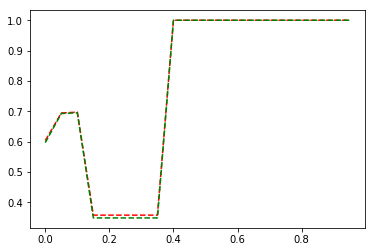

In [86]:
crossValidation(cleaned_with_median[1], split_y[1], 0.9, 6)

## Generate predictions and save ouput in csv format for submission:

In [21]:
DATA_TEST_PATH = '../data/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [3]:
OUTPUT_PATH = '../data/submission.csv'
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

NameError: name 'weights' is not defined